make some synthetic friges using Airy formulae


In [40]:
from pathlib import Path

import random
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import matplotlib


from ls_fringeapp import fringeprocess as fp
from ls_fringeapp.load_equipment_data import repo_folder
from ls_fringeapp import plot_helpers as ph

In [2]:
TEST_DATA_DIR = repo_folder / "tests" / "data"
fn1 = "MSL-01_08-R.jpg"
fn2 = "MSL-01_10-R.jpg"

# the right  side of "MSL-01_10-R.jpg" looks nice

In [3]:
img_filename = TEST_DATA_DIR / fn2
img = Image.open(img_filename)


(np.float64(-0.5), np.float64(755.5), np.float64(999.5), np.float64(-0.5))

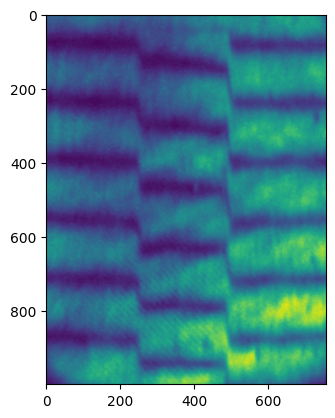

In [4]:
img_array = fp.img2greyarray(img)
plt.imshow(img_array)
plt.axis("image")

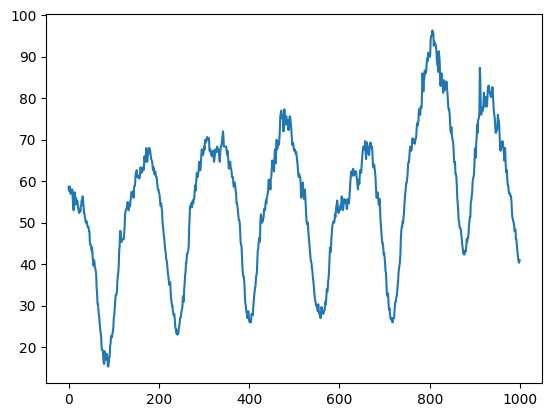

In [5]:
plt.plot(img_array[:, 600])

In [6]:
delta = np.linspace(0, 6 * np.pi, 200)
F = 1
i1 = (F * np.sin(delta / 2) ** 2) / (1 + F * np.sin(delta / 2) ** 2)
F = 200
i2 = (F * np.sin(delta / 2) ** 2) / (1 + F * np.sin(delta / 2) ** 2)


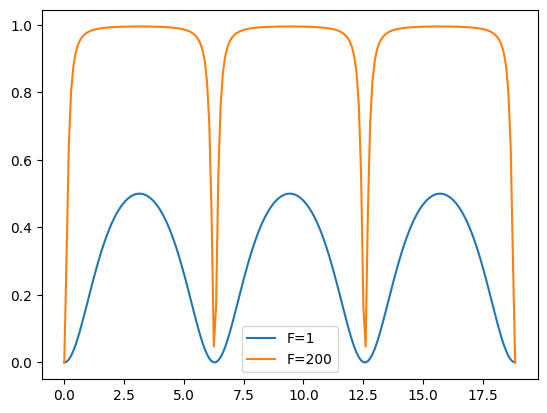

In [7]:
plt.plot(delta, i1, label="F=1")
plt.plot(delta, i2, label="F=200")
plt.legend()

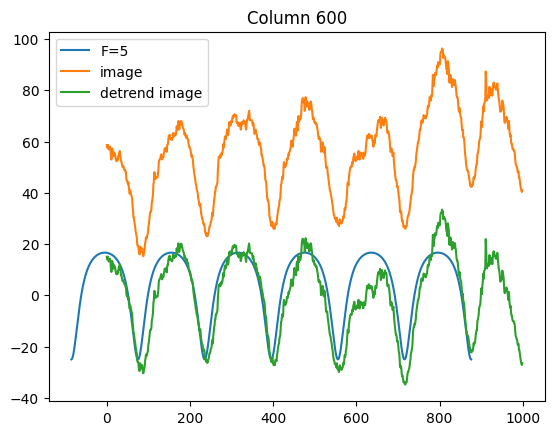

In [8]:
col = 600

F = 5
phase = 75
wavelength = 25.5

phase = phase - 2 * np.pi * wavelength
repeats = 12
amplitude = 50

delta = np.linspace(0, repeats * np.pi, 1000)

i1 = (F * np.sin(delta / 2) ** 2) / (1 + F * np.sin(delta / 2) ** 2)

x = delta * wavelength + phase
y = amplitude * (i1 - 0.5)

plt.plot(x, y, label=f"{F=}")
plt.plot(img_array[:, col], label="image")

yi = matplotlib.mlab.detrend_linear(img_array[:, col])
plt.plot(yi, label="detrend image")
plt.title(f"Column {col}")
plt.legend()


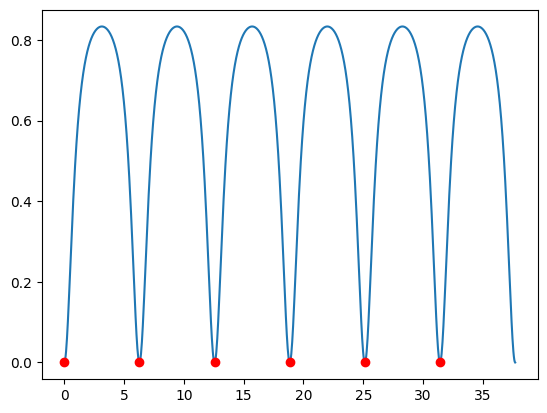

In [9]:
plt.plot(delta, i1)
xpi = np.arange(0, np.pi * repeats, 2 * np.pi)
plt.plot(xpi, np.zeros_like(xpi), "ro")

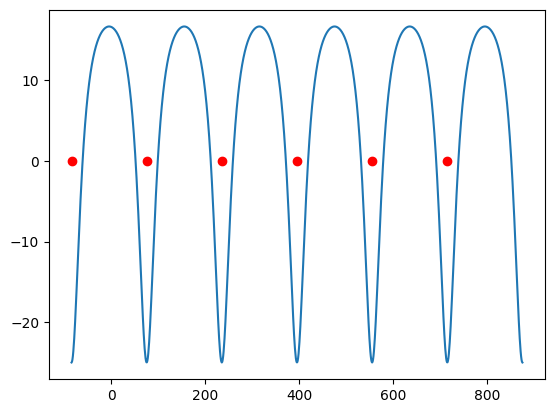

In [10]:
plt.plot(x, y)
xrep = np.arange(0, np.pi * repeats, 2 * np.pi)
xrep = xrep * wavelength + phase
plt.plot(xrep, np.zeros_like(xrep), "ro")

In [11]:
np.diff(xrep)[0], 2 * np.pi * wavelength

(np.float64(160.22122533307945), 160.22122533307945)

In [12]:
# calulate inrensity  as function of pixel position x

size = (1000, 1000)
F = 5
phase = 510
spacing_px = 100
offset_px = 50


repeats = 12
amplitude = 50
mean_intensity = 50

x = np.arange(0, 1000)
delta2 = 2 * np.pi * (x - offset_px) / spacing_px

i12 = (F * np.sin(delta2 / 2) ** 2) / (1 + F * np.sin(delta2 / 2) ** 2)

y2 = amplitude * (i12 - 0.5) + mean_intensity


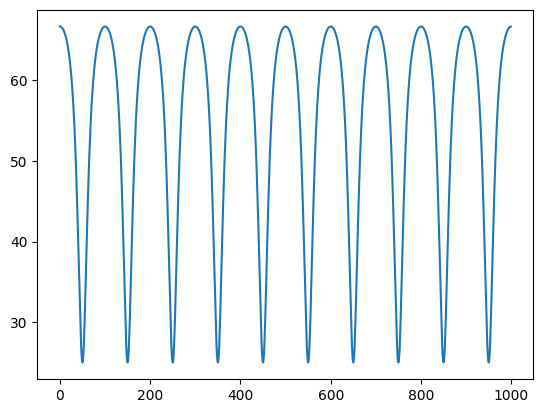

In [13]:
plt.plot(y2)

In [14]:
img_array = np.empty((1000, 1000))
img_array[:] = y2
img_array = img_array.T

(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

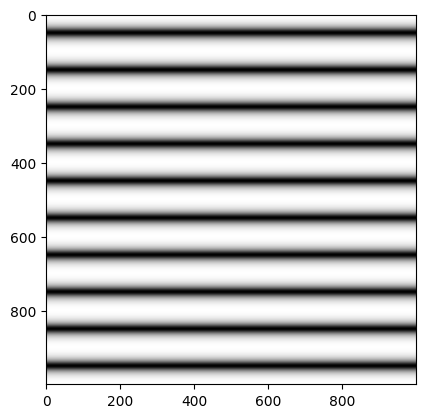

In [15]:
plt.imshow(img_array, cmap=matplotlib.cm.gray)
plt.axis("image")

In [16]:
# find the fringe spacing in pixels

pklist = fp.pkfind(img_array)
y = img_array[:, 0]  # 1st column of array
bwp = np.ones_like(img_array)
slope, intercepts = fp.findfringes2(y, bwp, pklist)
spacing = np.diff(intercepts).mean()
spacing

np.float64(100.00003477380898)

In [17]:
pklist[0]

array([ 49.99567229, 149.9958484 , 249.99597306, 349.99607585,
       449.99613056, 549.99612242, 649.99605949, 749.99597213,
       849.99590777, 949.99598525])

In [18]:
intercepts

array([ 49.99567229, 149.9958484 , 249.99597306, 349.99607585,
       449.99613056, 549.99612242, 649.99605949, 749.99597213,
       849.99590777, 949.99598525])

In [19]:
np.diff(intercepts)

array([100.00017611, 100.00012466, 100.00010279, 100.00005471,
        99.99999186,  99.99993707,  99.99991264,  99.99993563,
       100.00007749])

In [20]:
def synthetic_fringes(
    spacing_px,
    offset_px,
    size,
    amplitude=50,
    mean_intensity=50,
    finesse=5,
):
    x = np.arange(0, size[0])
    # delta as multiple of 2pi
    delta = 2 * np.pi * (x - offset_px) / spacing_px

    z_int = (finesse * np.sin(delta / 2) ** 2) / (1 + finesse * np.sin(delta / 2) ** 2)
    z = amplitude * (z_int - 0.5) + mean_intensity
    img_array = np.empty(size).T
    img_array[:] = z
    img_array = img_array.T
    return img_array

(np.float64(-0.5), np.float64(399.5), np.float64(849.5), np.float64(-0.5))

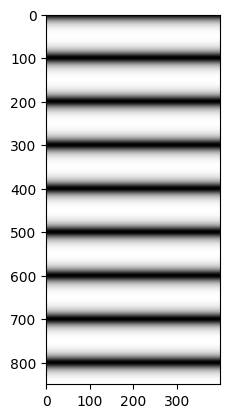

In [21]:
a1 = synthetic_fringes(100, 0, (850, 400))
plt.imshow(a1, cmap=matplotlib.cm.gray)
plt.axis("image")

In [22]:
img = Image.fromarray(a1)
img.show()

In [23]:
img.mode

'F'

In [24]:
def synthetic_image_with_gauge(
    fringe_spacing_px,
    offset_px,
    ffrac,
    img_size_px,
    gb_size_px,
    amplitude=50,
    mean_intensity=50,
    finesse=5,
):
    img_array = synthetic_fringes(
        fringe_spacing_px,
        offset_px,
        img_size_px,
        amplitude,
        mean_intensity,
        finesse,
    )
    # convert to PIL image
    img = Image.fromarray(img_array)
    # make a copy so the  orignal image is not altered
    img2 = img.copy()

    # shift by fringe_fraction
    yshift = (1, 0, 0, 0, 1, ffrac * fringe_spacing_px)
    img3 = img2.transform(img2.size, Image.Transform.AFFINE, data=yshift)
    gb_box = (0, 0, gb_size_px[1], gb_size_px[0])
    # crop shifted copy to gauge size
    img4 = img3.crop(gb_box)
    # paste to centre of image
    top_left = ((img.size[0] - gb_size_px[1]) // 2, (img.size[1] - gb_size_px[0]) // 2)
    img2.paste(img4, top_left)
    # convert back to numpy array
    img_array = np.asarray(img2)
    # gauge coordinates in format needed for array2frac
    gb_xy = np.array(
        [
            top_left,
            (top_left[0], top_left[1] + gb_size_px[0]),
            (top_left[0] + gb_size_px[1], top_left[1] + gb_size_px[0]),
        ]
    )
    gb_yx = gb_xy[:, [1, 0]]

    return img_array, gb_yx


In [25]:
ffrac_set = 0.5
a1, gb_yx = synthetic_image_with_gauge(60, 0, ffrac_set, (800, 400), (600, 200))
gb_yx

array([[100, 100],
       [700, 100],
       [700, 300]])

(np.float64(-0.5), np.float64(399.5), np.float64(799.5), np.float64(-0.5))

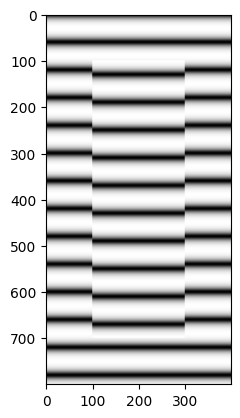

In [26]:
plt.imshow(a1, cmap=matplotlib.cm.gray)
plt.axis("image")

In [27]:
ffrac_calc, drawdata = fp.array2frac(a1, gb_yx, drawinfo=True)

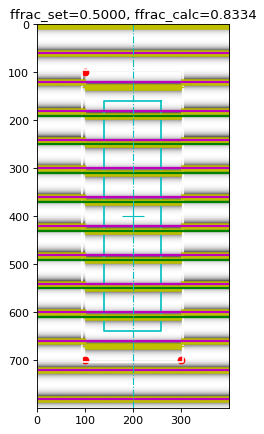

In [28]:
fig = plt.figure(figsize=(6, 6), dpi=80)
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.set_title(f"{ffrac_set=:.4f}, {ffrac_calc=:.4f}")
ph.draw_gauge(axes, a1, drawdata)

In [29]:
ffracs = []
for ffrac_set in np.arange(0, 1, 0.01):
    a1, gb_yx = synthetic_image_with_gauge(100, 0, ffrac_set, (800, 400), (600, 200))
    ffrac_calc = fp.array2frac(a1, gb_yx, drawinfo=False)
    ffracs.append([ffrac_set, ffrac_calc])

ffracs = np.array(ffracs)


In [30]:
diff = ffracs[:, 1] - ffracs[:, 0]
diff.shape, diff.mean(), diff.std(ddof=1), diff.max(), diff.min()

((100,),
 np.float64(2.5299045421735794e-06),
 np.float64(0.00028699911616897035),
 np.float64(0.0005147582003061646),
 np.float64(-0.0005072022651207986))

In [31]:
0.0005 * 633 / 2

0.15825

In [32]:
from ls_fringeapp import synthetic_images as si

ffracs2 = []
for ffrac_set in np.arange(0, 1, 0.01):
    a1, gb_yx = si.synthetic_image_with_gauge(100, 0, ffrac_set, (800, 400), (600, 200))
    ffrac_calc = fp.array2frac(a1, gb_yx, drawinfo=False)
    ffracs2.append([ffrac_set, ffrac_calc])

ffracs2 = np.array(ffracs2)

In [33]:
diff2 = ffracs2[:, 1] - ffracs2[:, 0]
diff2.shape, diff2.mean(), diff2.std(ddof=1), diff2.max(), diff2.min()

((100,),
 np.float64(2.5299045421735794e-06),
 np.float64(0.00028699911616897035),
 np.float64(0.0005147582003061646),
 np.float64(-0.0005072022651207986))

In [34]:
# in Metrologia paper I reported stdev of 0.001 fringe for 20 mmts of synthetic images
# levene test except I only have stdev
from scipy import stats


In [ ]:
# f-test
var1 = 0.001**2
df1 = 19
var2 = diff.var(ddof=1)
df2 = 99
f_value = var1 / var2
p_value = stats.f.sf(f_value, df1, df2)
p_value


np.float64(3.2733163969284096e-18)

In [ ]:
stats.f.sf(var1 / var2, 19, 99)

np.float64(3.2733163969284096e-18)

p_value is less than 0.05 so variances are different

In [ ]:
# check I've got this f-test correct around the right way
group1 = np.random.normal(loc=20, scale=5, size=100)
# different mean same variance
group2 = np.random.normal(loc=100, scale=5, size=20)
# same mean different varaince
group3 = np.random.normal(loc=20, scale=1, size=20)
p12 = stats.f.sf(group1.var(ddof=1) / group2.var(ddof=1), 99, 19)
p13 = stats.f.sf(group1.var(ddof=1) / group3.var(ddof=1), 99, 19)
p12, p13


(np.float64(0.3068913925117228), np.float64(2.0549331269835804e-10))

In [ ]:
# add some randomness
n_tests = 100
img_size = (800, 400)
gb_size = (600, 200)
ffracs = []
for i in range(n_tests):
    ffrac_set = random.uniform(0.0, 1.0)
    spacing = 100
    offset = 0

    a1, gb_yx = si.synthetic_image_with_gauge(
        spacing,
        offset,
        ffrac_set,
        img_size,
        gb_size,
    )
    ffrac_calc = fp.array2frac(a1, gb_yx, drawinfo=False)
    ffracs.append([ffrac_set, ffrac_calc])

ffracs = np.array(ffracs)
diff = ffracs[:, 1] - ffracs[:, 0]
diff.shape, diff.mean(), diff.std(ddof=1), diff.max(), diff.min()

((100,),
 np.float64(-0.019758159553683163),
 np.float64(0.1405336167232808),
 np.float64(0.005075129433719794),
 np.float64(-0.9988416916469348))

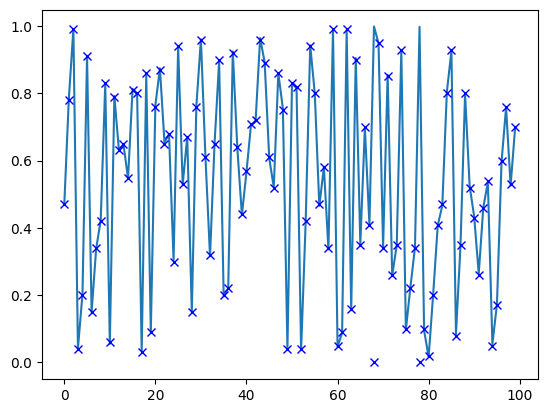

In [ ]:
plt.plot(ffracs[:, 0])
plt.plot(ffracs[:, 1], "bx")


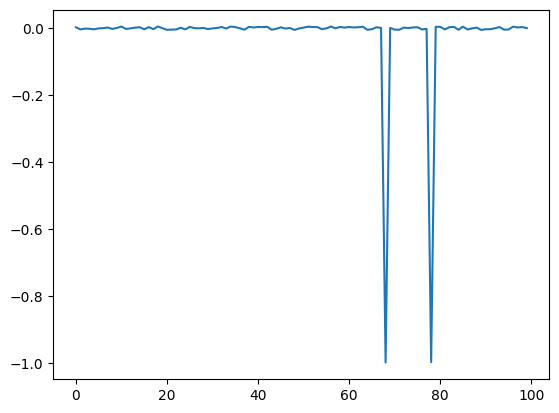

In [50]:
plt.plot(diff)

In [62]:
print(f"{ffracs[68, :]=}")

ffracs[68, :]=array([9.98841692e-01, 8.91123295e-15])


In [ ]:
# add some randomness
# and skip the area just on 0 and 1 to  avoid wrap around
n_tests = 100
img_size = (800, 400)
gb_size = (600, 200)
ffracs = []
skip_margin = 1e-3  # skip numbers near zero and 1 to avoid wrap around errors. HACKY
for i in range(n_tests):
    ffrac_set = random.uniform(0.0 + skip_margin, 1.0 - skip_margin)
    spacing = 100
    offset = 0

    a1, gb_yx = si.synthetic_image_with_gauge(
        spacing,
        offset,
        ffrac_set,
        img_size,
        gb_size,
    )
    ffrac_calc = fp.array2frac(a1, gb_yx, drawinfo=False)
    ffracs.append([ffrac_set, ffrac_calc])

ffracs = np.array(ffracs)
diff = ffracs[:, 1] - ffracs[:, 0]
diff.shape, diff.mean(), diff.std(ddof=1), diff.max(), diff.min()

((100,),
 np.float64(-0.0003110275650439559),
 np.float64(0.002875024436645831),
 np.float64(0.0051144075915766085),
 np.float64(-0.005202071732970048))

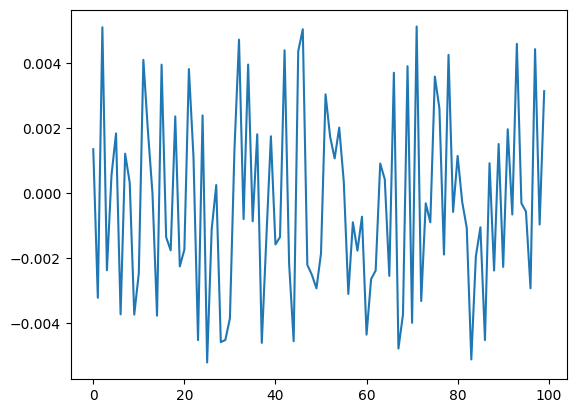

In [64]:
plt.plot(diff)

Text(0, 0.5, 'difference')

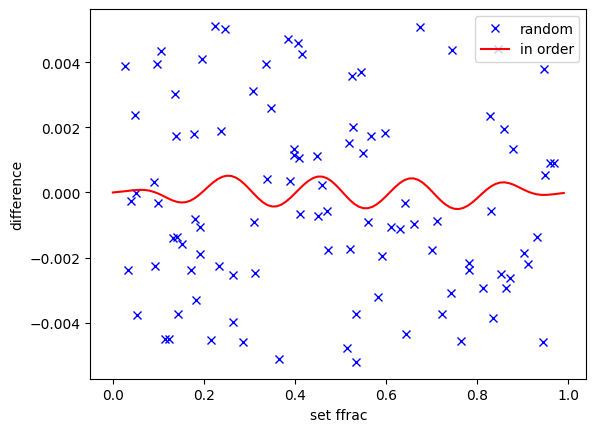

In [ ]:
plt.plot(ffracs[:, 0], diff, "bx", label="random")
plt.plot(ffracs2[:, 0], diff2, "r", label="in order")
plt.legend()
plt.xlabel("set ffrac")
plt.ylabel("difference")